# Week 3 Assignment - Plant Seedlings Dataset - Bimalendu Mishra

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import gc

from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]
plt.style.use('fivethirtyeight')

#Tensorflow Dependencies

import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAvgPool2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess_input

import warnings
warnings.simplefilter('ignore')

## Loading Data

In [2]:
def ImageReader(location, size=(224, 224)):
    img = image.load_img(location, target_size=size)
    img = image.img_to_array(img)
    
    return img

class LoadData(object):
    
    def __init__(self, image_size=(224, 224)):
        
        self.SetSeed()
        self.image_size=image_size
        
        self.CATEGORIES = os.listdir("../input/plant-seedlings-classification/train/")
        self.N_CLASSES = len(self.CATEGORIES)
        print(f"Length of Categories : {self.N_CLASSES}")
        self.data_dir = "../input/plant-seedlings-classification/"
        self.train_dir = os.path.join(self.data_dir, "train")
        self.test_dir = os.path.join(self.data_dir, "test")
        self.sub = pd.read_csv("../input/plant-seedlings-classification/sample_submission.csv")

        print(f"Sub Shape : {self.sub.shape}")
    
    def SetSeed(self, seed=13):
        
        self.seed = seed
        np.random.seed(self.seed)
    
    def PlotDistribution(self, print_cat_wise=False):
        
        distribution = {}

        for category in self.CATEGORIES:
            num_samples = len(os.listdir(os.path.join(self.train_dir, category)))
            distribution[category] = num_samples
            if print_cat_wise:
                print(f"{category} has {num_samples} samples.")

        plt.figure(figsize=(24, 12))
        plt.xlabel("Category")
        plt.ylabel("Count")
        plt.title("Target Distribution")
        sns.barplot(list(distribution.keys()), list(distribution.values()))
        plt.show()
    
    def RetrieveData(self):
        
        
        
        self.train = []
        self.test = []
        self.class_names = {}
        
        for category_id, category in tqdm_notebook(enumerate(self.CATEGORIES)):
            category_path = os.path.join(self.train_dir, category)
            cur_cat_files = os.listdir(category_path)
            cur_cat_files = [[os.path.join(category_path, i), category, category_id] for i in cur_cat_files]
            
            if not self.class_names.get(category):
                self.class_names[category] = category_id
            
            self.train.extend(cur_cat_files)

        print(f"Total Train Samples : {len(self.train)}")
        self.train = pd.DataFrame(self.train, columns=['location', 'target', 'target_id'])
        
        for file in tqdm_notebook(os.listdir(self.test_dir)):
            cur_item = os.path.join(self.test_dir, file)
            self.test.append(cur_item)

        print(f"Total Test Samples : {len(self.test)}")
        self.test = pd.DataFrame(self.test, columns=['location'])
        
        self.SplitData()
    
    def SplitData(self):

        self.train, self.valid, self.y_train, self.y_valid = train_test_split(self.train, self.train['target_id'], test_size=0.2, random_state=self.seed)
        print(f"Train Shape : {self.train.shape}\nValid Shape : {self.valid.shape}\n")
        
    
    def MakeDatagen(self, batch_size=32):

        self.batch_size = batch_size
        
        self.train_gen = self.data_gen.flow_from_dataframe(
            dataframe=self.train, 
            x_col='location',
            y_col='target',
            batch_size=self.batch_size,
            seed=LoadData.seed,
            shuffle=False, 
            class_mode='categorical',
            target_size=self.image_size,
        )

        self.valid_gen = self.data_gen.flow_from_dataframe(
            dataframe=self.valid, 
            x_col='location',
            y_col='target',
            batch_size=self.batch_size,
            seed=LoadData.seed,
            shuffle=False, 
            class_mode='categorical',
            target_size=self.image_size,
        )

        self.test_gen = self.data_gen.flow_from_dataframe(
            dataframe=self.test, 
            x_col='location',
            y_col=None,
            batch_size=1,  
            seed=LoadData.seed,
            shuffle=False,
            class_mode=None,
            target_size=self.image_size,
        )

        self.train_stepsize = self.train_gen.n // self.train_gen.batch_size
        self.valid_stepsize = self.valid_gen.n // self.valid_gen.batch_size
        
        return (self.train_gen, self.train_stepsize), (self.valid_gen, self.valid_stepsize), self.test_gen
    

    
    
    
    def SetDatagen(self, data_gen=ImageDataGenerator(rescale=1./255)):
        self.data_gen = data_gen
        
    
    def SetImageSize(self, image_size=(224, 224)):
        
        self.image_size = image_size
        

Length of Categories : 12
Sub Shape : (794, 2)



Total Train Samples : 4750



Total Test Samples : 794
Train Shape : (3800, 3)
Valid Shape : (950, 3)



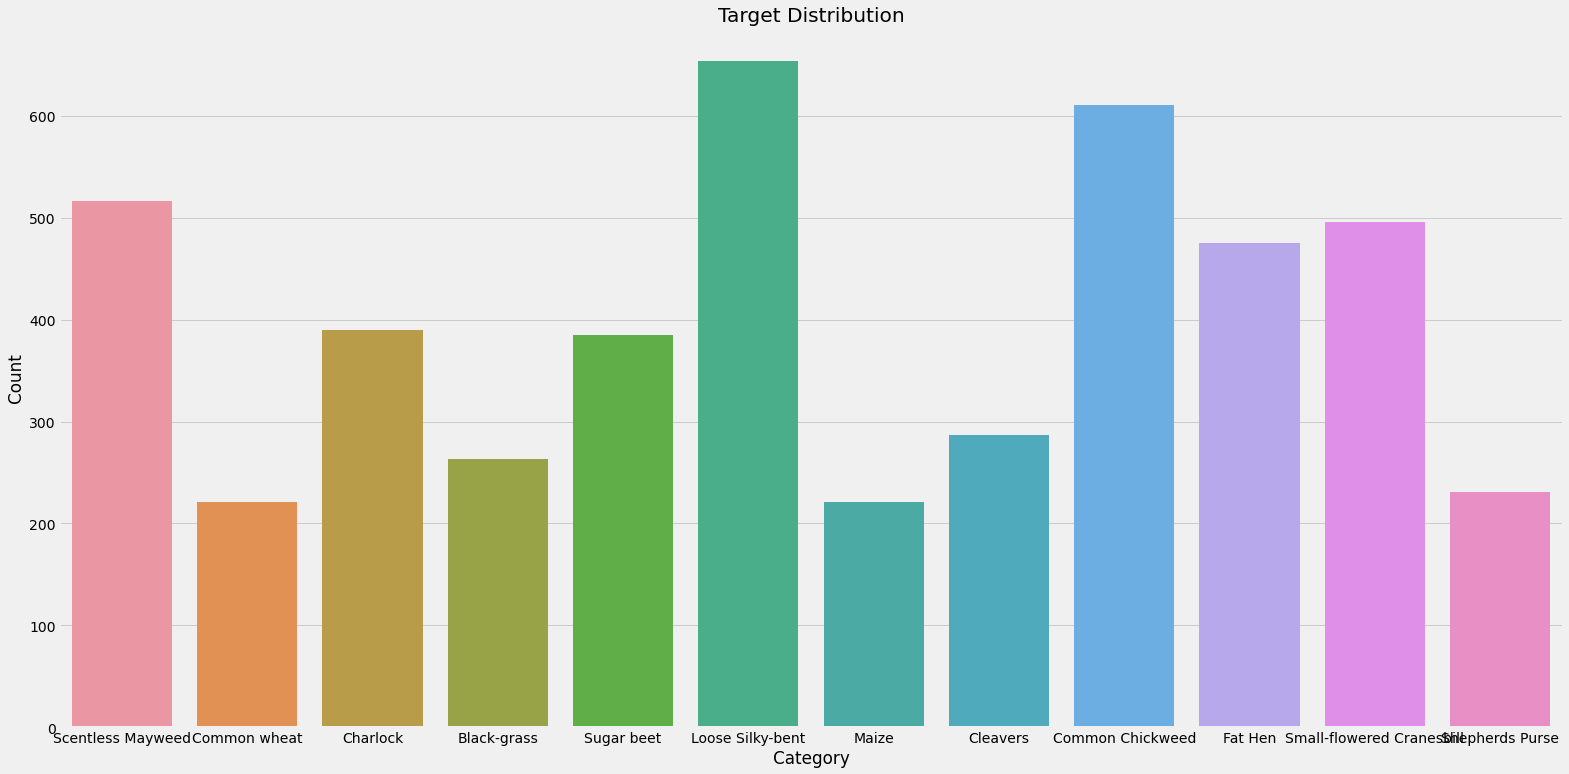

In [3]:
LoadData = LoadData(image_size=(224, 224))
LoadData.RetrieveData()
LoadData.PlotDistribution()

## Data Modelling

In [4]:
class pre_trained_models(object):
    
    def __init__(self):
        
        self.model_utils = {
            'resnet_50': {
                'model': ResNet50,
                'preprocessor': resnet_preprocess_input,
            },
            'vgg_16': {
                'model': VGG16,
                'preprocessor':vgg_preprocess_input,
            },
            'inception_v3': {
                'model': InceptionV3,
                'preprocessor': inception_preprocess_input,
            },
        }
        
        self.loss_history = {
            'resnet_50': {},
            'vgg_16': {},
            'inception_v3': {},
        }
    
    
    def ModelTuning(self, LoadData, choice, params):
        
        self.params = params
        
        self.pre_trained_model = self.model_utils[choice]['model']
        self.pre_trained_model_preprocessor = self.model_utils[choice]['preprocessor']
        
        self.datagen = ImageDataGenerator(preprocessing_function=self.pre_trained_model_preprocessor)
        LoadData.SetDatagen(self.datagen)
        
        (self.train_gen, self.train_stepsize), (self.valid_gen, self.valid_stepsize), self.test_gen = LoadData.MakeDatagen(self.params['batch_size'])
        
       
        
        early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=3)
        reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.00001)
        
        print("\nDownloading & Compiling the model ... ")
        self.model_name = choice
        input_shape = (LoadData.image_size[0], LoadData.image_size[1], 3)
        if choice == 'vgg_16':

            file_path = "best_vgg16.hdf5"
            checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1)
            
           
            VggModel16 = self.pre_trained_model(include_top=False, input_shape=input_shape)

            
            for layer in VggModel16.layers:
                layer.trainable = False
                
            x = Flatten()(VggModel16.output)
            x = Dense(512)(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Dropout(0.8)(x)
            x = BatchNormalization()(x)
            x = Dense(LoadData.N_CLASSES, activation='softmax')(x)

            self.model = Model(inputs=VggModel16.input, outputs=x)
            
        elif choice == 'resnet_50':

            file_path = "best_resnet50.hdf5"
            checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1)

            
            ResnetModel50 = self.pre_trained_model(include_top=False, input_shape=input_shape)

            for layer in ResnetModel50.layers:
                layer.trainable = False

            x = Flatten()(ResnetModel50.output)
            x = Dense(512)(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Dropout(0.8)(x)
            x = BatchNormalization()(x)
            x = Dense(LoadData.N_CLASSES, activation='softmax')(x)

            self.model = Model(inputs=ResnetModel50.input, outputs=x)
            
        elif choice == 'inception_v3':
            
            file_path = "best_inceptionv3.hdf5" 
            checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1)
            
        
            ModelInception = self.pre_trained_model(include_top=False, input_shape=input_shape)

            for layer in ModelInception.layers:
                layer.trainable = False

            x = Flatten()(ModelInception.output)
            x = Dense(512)(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Dropout(0.8)(x)
            x = BatchNormalization()(x)
            x = Dense(LoadData.N_CLASSES, activation='softmax')(x)

            self.model = Model(inputs=ModelInception.input, outputs=x)
            
        else:
            return "Choose correct model."
        
        
        optimizer = Adam() 
        self.model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

        print("Compiled.")
        print(f"Fitting Model : {self.model_name} .. ", end='\n\n')
        
        hist = self.model.fit_generator(
            generator = self.train_gen,
            validation_data = self.valid_gen,
            steps_per_epoch = self.train_stepsize,
            validation_steps = self.valid_stepsize,
            epochs = self.params['epochs'],
            verbose = 1,
            callbacks=[checkpoint, early_stopping, reduce_lr],
        )
        
        self.loss_history[choice] = hist.history
        
        return self.model
    
    def PlotSingleMetric(self, choice):
        
        history = self.loss_history[choice]

        epoch_range = [i+1 for i, loss in enumerate(history['loss'])]
        xticks = range(0, max(epoch_range), 2)

        max_loss = max([max(history['loss']), max(history['val_loss'])])
        min_loss = min([min(history['loss']), min(history['val_loss'])])
        max_acc = max([max(history['accuracy']), max(history['val_accuracy'])])
        min_acc = min([min(history['accuracy']), min(history['val_accuracy'])])

        plt.figure(figsize=(18, 7))

        plt.subplot(1, 2, 1)
        plt.plot(epoch_range, history['loss'], color='red', label='Train')
        plt.plot(epoch_range, history['val_loss'], color='green', label='Valid')
        plt.xticks(xticks)
        plt.yticks(np.linspace(min_loss, max_loss, 10))
        plt.grid(False)
        plt.legend(loc='best')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f"{self.model_name} | Loss Curve")

        plt.subplot(1, 2, 2)
        plt.plot(epoch_range, history['accuracy'], color='red', label='Train')
        plt.plot(epoch_range, history['val_accuracy'], color='green', label='Valid')
        plt.xticks(xticks)
        plt.yticks(np.linspace(min_acc, max_acc, 10))
        plt.grid(False)
        plt.legend(loc='best')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f"{self.model_name} | Accuracy Curve")

        plt.tight_layout()
        plt.show()
        
    def plot_multiple_metric(self):
        
        history_1 = self.loss_history['vgg_16']
        history_2 = self.loss_history['resnet_50']
        history_3 = self.loss_history['inception_v3']

        epoch_range = [i+1 for i, loss in enumerate(history_1['loss'])]
        xticks = range(0, max(epoch_range), 2)

        plt.figure(figsize=(18, 18))

        
        plt.subplot(2, 1, 1)
        plt.plot(epoch_range, history_1['val_loss'], color='red', label='VGG-16')
        plt.plot(epoch_range, history_2['val_loss'], color='green', label='Resnet-50')
        plt.plot(epoch_range, history_3['val_loss'], color='purple', label='Inception-v3')
        plt.xticks(xticks)
        plt.grid(False)
        plt.legend(loc='best')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f"Validation Loss Comparision")

        
        plt.subplot(2, 1, 2)
        plt.plot(epoch_range, history_1['val_accuracy'], color='red', label='VGG-16')
        plt.plot(epoch_range, history_2['val_accuracy'], color='green', label='Resnet-50')
        plt.plot(epoch_range, history_3['val_accuracy'], color='purple', label='Inception-v3')
        plt.xticks(xticks)
        plt.grid(False)
        plt.legend(loc='best')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f"Validation Accuracy Comparision")

        plt.tight_layout()
        plt.show()
        
    def plot_confusion_matrix(self, LoadData, model, model_name):
        
        y_pred = model.predict_generator(LoadData.valid_gen)
        y_pred = np.argmax(y_pred, axis=1)

        con_mat = tf.math.confusion_matrix(labels=LoadData.valid_gen.classes, predictions=y_pred).numpy()
        con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
        con_mat_df = pd.DataFrame(con_mat_norm,
                             index = list(LoadData.class_names.keys()), 
                             columns = list(LoadData.class_names.keys()))

        fig = plt.figure(figsize=(16, 16))
        sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title(f'{model_name} Confusion Matrix')

        plt.show()

In [5]:
params = {
    'batch_size': 128,
    'epochs': 10,
}

In [6]:
TransModels = pre_trained_models()

## Inception Model

Found 3800 validated image filenames belonging to 12 classes.
Found 950 validated image filenames belonging to 12 classes.
Found 794 validated image filenames.

87916544/87910968 [==============================] - 1s 0us/step
Compiled.
Fitting Model : inception_v3 .. 

Epoch 1/10
29/29 [==============================] - ETA: 0s - loss: 1.8498 - accuracy: 0.4150
Epoch 00001: val_accuracy improved from -inf to 0.62612, saving model to best_inceptionv3.hdf5
29/29 [==============================] - 112s 4s/step - loss: 1.8498 - accuracy: 0.4150 - val_loss: 1.7999 - val_accuracy: 0.6261 - lr: 0.0010
Epoch 2/10
29/29 [==============================] - ETA: 0s - loss: 1.1174 - accuracy: 0.6329
Epoch 00002: val_accuracy improved from 0.62612 to 0.71875, saving model to best_inceptionv3.hdf5
29/29 [==============================] - 65s 2s/step - loss: 1.1174 - accuracy: 0.6329 - val_loss: 0.9147 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 3/10
29/29 [==============================] - ETA: 0s - lo

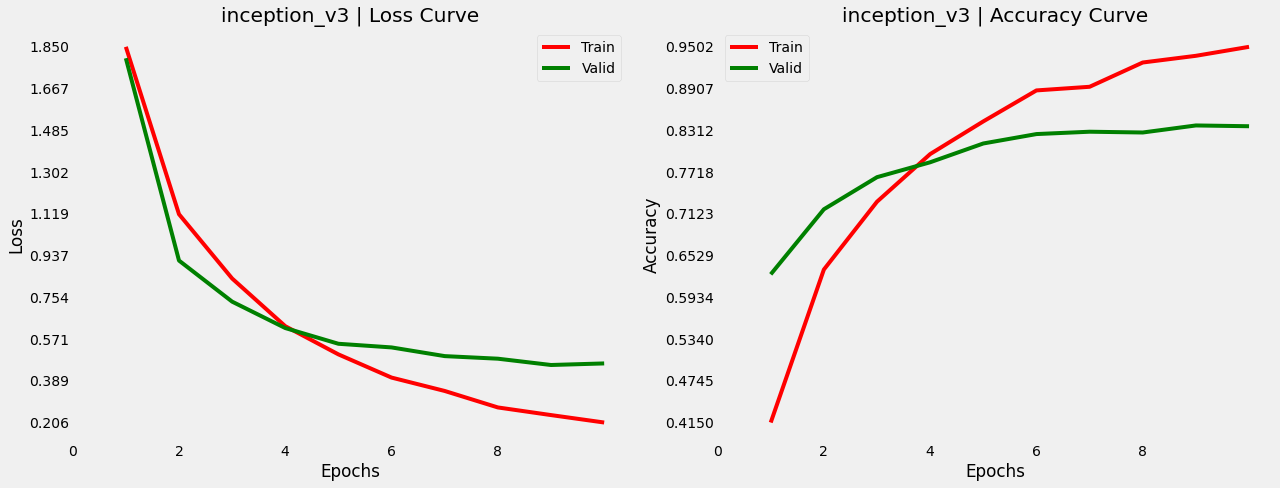

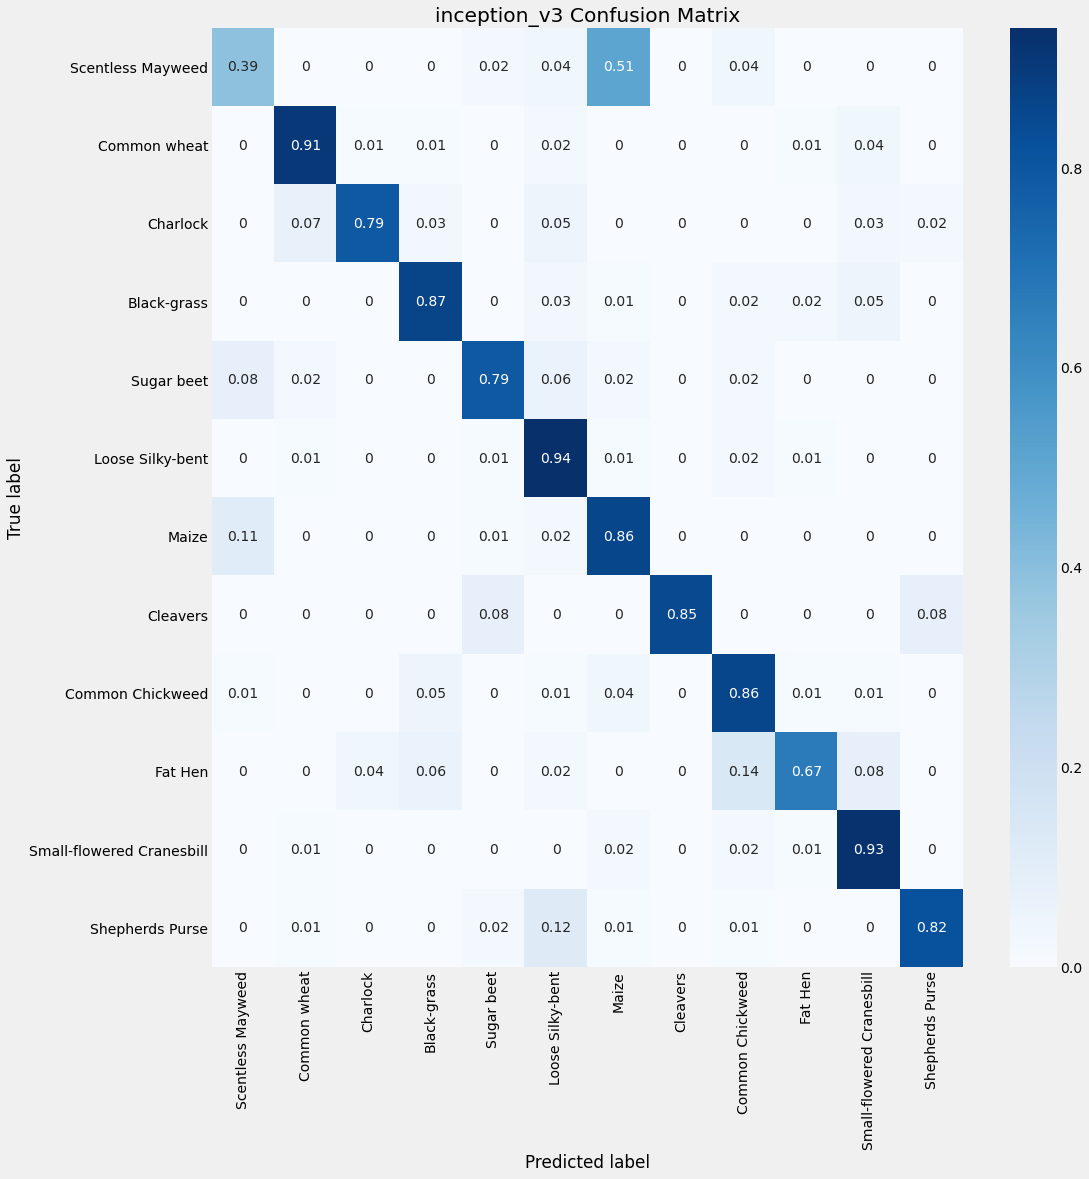

In [7]:
ModelInception = TransModels.ModelTuning(LoadData=LoadData, choice='inception_v3', params=params)
TransModels.PlotSingleMetric(choice='inception_v3')
TransModels.plot_confusion_matrix(LoadData=LoadData, model=ModelInception, model_name='inception_v3')

In [8]:
ModelInception.save("inception_v3.h5")

## VGG Model

Found 3800 validated image filenames belonging to 12 classes.
Found 950 validated image filenames belonging to 12 classes.
Found 794 validated image filenames.

58892288/58889256 [==============================] - 0s 0us/step
Compiled.
Fitting Model : vgg_16 .. 

Epoch 1/10
29/29 [==============================] - ETA: 0s - loss: 1.9148 - accuracy: 0.4006
Epoch 00001: val_accuracy improved from -inf to 0.61049, saving model to best_vgg16.hdf5
29/29 [==============================] - 66s 2s/step - loss: 1.9148 - accuracy: 0.4006 - val_loss: 1.7311 - val_accuracy: 0.6105 - lr: 0.0010
Epoch 2/10
29/29 [==============================] - ETA: 0s - loss: 0.9454 - accuracy: 0.7059
Epoch 00002: val_accuracy improved from 0.61049 to 0.71317, saving model to best_vgg16.hdf5
29/29 [==============================] - 67s 2s/step - loss: 0.9454 - accuracy: 0.7059 - val_loss: 0.9286 - val_accuracy: 0.7132 - lr: 0.0010
Epoch 3/10
29/29 [==============================] - ETA: 0s - loss: 0.5990 - accura

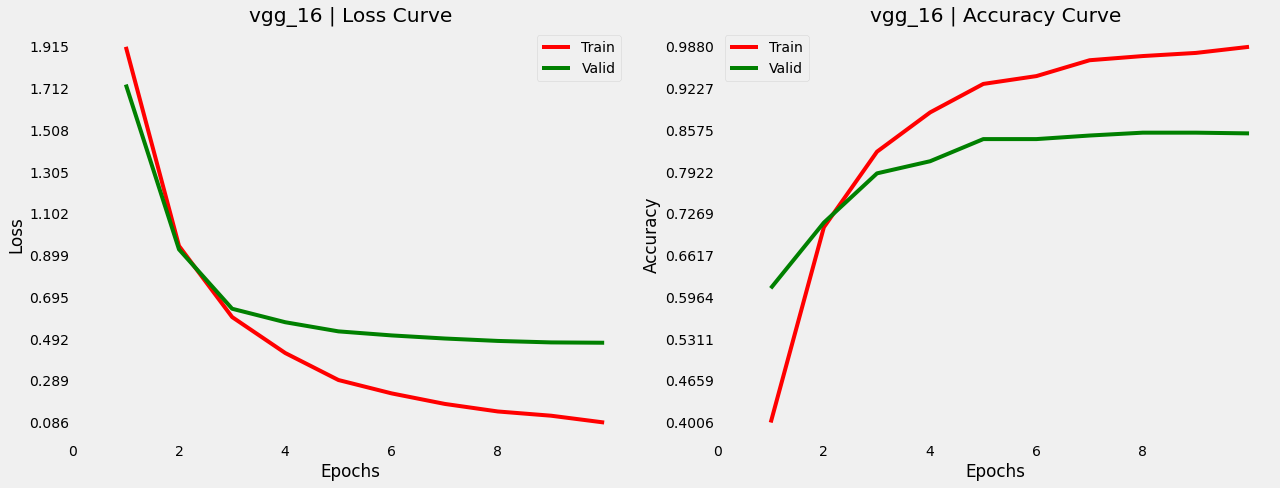

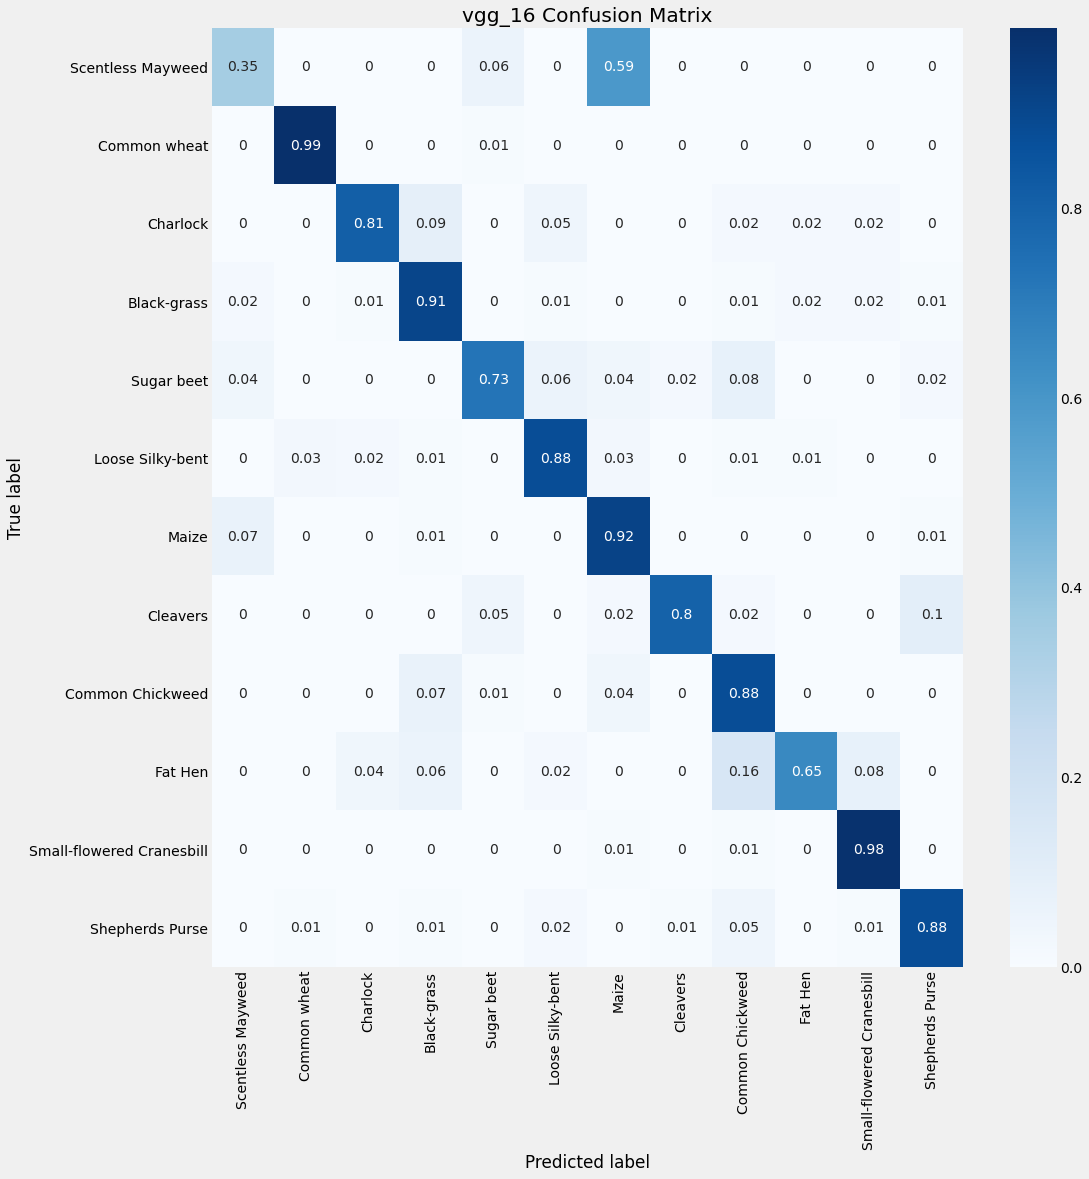

In [9]:
VggModel = TransModels.ModelTuning(LoadData=LoadData, choice='vgg_16', params=params)
TransModels.PlotSingleMetric(choice='vgg_16')
TransModels.plot_confusion_matrix(LoadData=LoadData, model=VggModel, model_name='vgg_16')

In [10]:
VggModel.save("vgg_16.h5")

## ResNet Model

Found 3800 validated image filenames belonging to 12 classes.
Found 950 validated image filenames belonging to 12 classes.
Found 794 validated image filenames.

94773248/94765736 [==============================] - 0s 0us/step
Compiled.
Fitting Model : resnet_50 .. 

Epoch 1/10
29/29 [==============================] - ETA: 0s - loss: 1.6601 - accuracy: 0.4654
Epoch 00001: val_accuracy improved from -inf to 0.66295, saving model to best_resnet50.hdf5
29/29 [==============================] - 68s 2s/step - loss: 1.6601 - accuracy: 0.4654 - val_loss: 1.5643 - val_accuracy: 0.6629 - lr: 0.0010
Epoch 2/10
29/29 [==============================] - ETA: 0s - loss: 0.8337 - accuracy: 0.7413
Epoch 00002: val_accuracy improved from 0.66295 to 0.77344, saving model to best_resnet50.hdf5
29/29 [==============================] - 68s 2s/step - loss: 0.8337 - accuracy: 0.7413 - val_loss: 0.7004 - val_accuracy: 0.7734 - lr: 0.0010
Epoch 3/10
29/29 [==============================] - ETA: 0s - loss: 0.5217

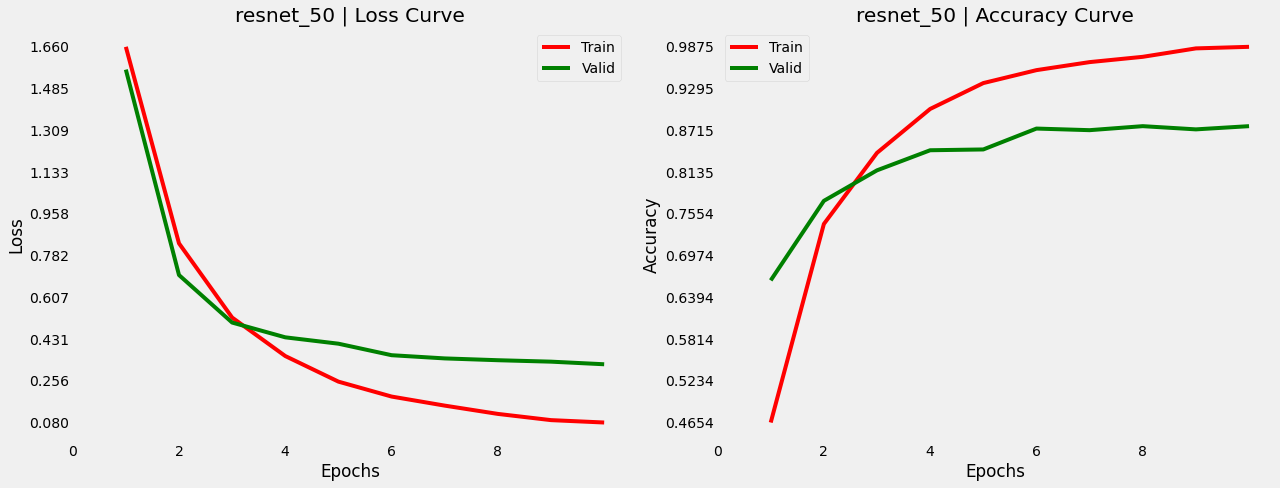

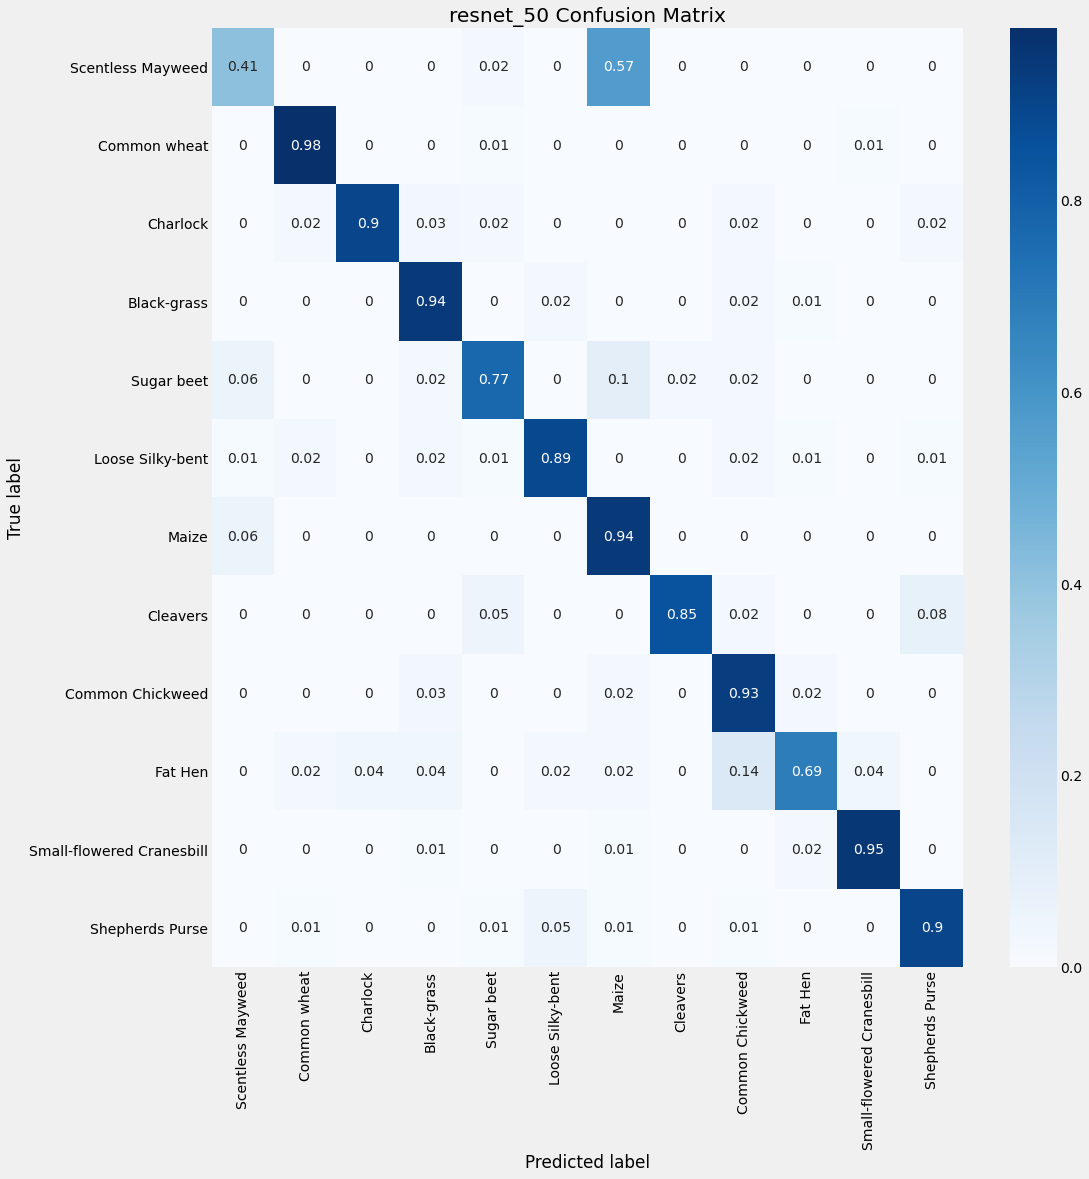

In [11]:
ResnetModel = TransModels.ModelTuning(LoadData=LoadData, choice='resnet_50', params=params)
TransModels.PlotSingleMetric(choice='resnet_50')
TransModels.plot_confusion_matrix(LoadData=LoadData, model=ResnetModel, model_name='resnet_50')

In [12]:
ResnetModel.save("resnet_50.h5")

### Multiple Plots

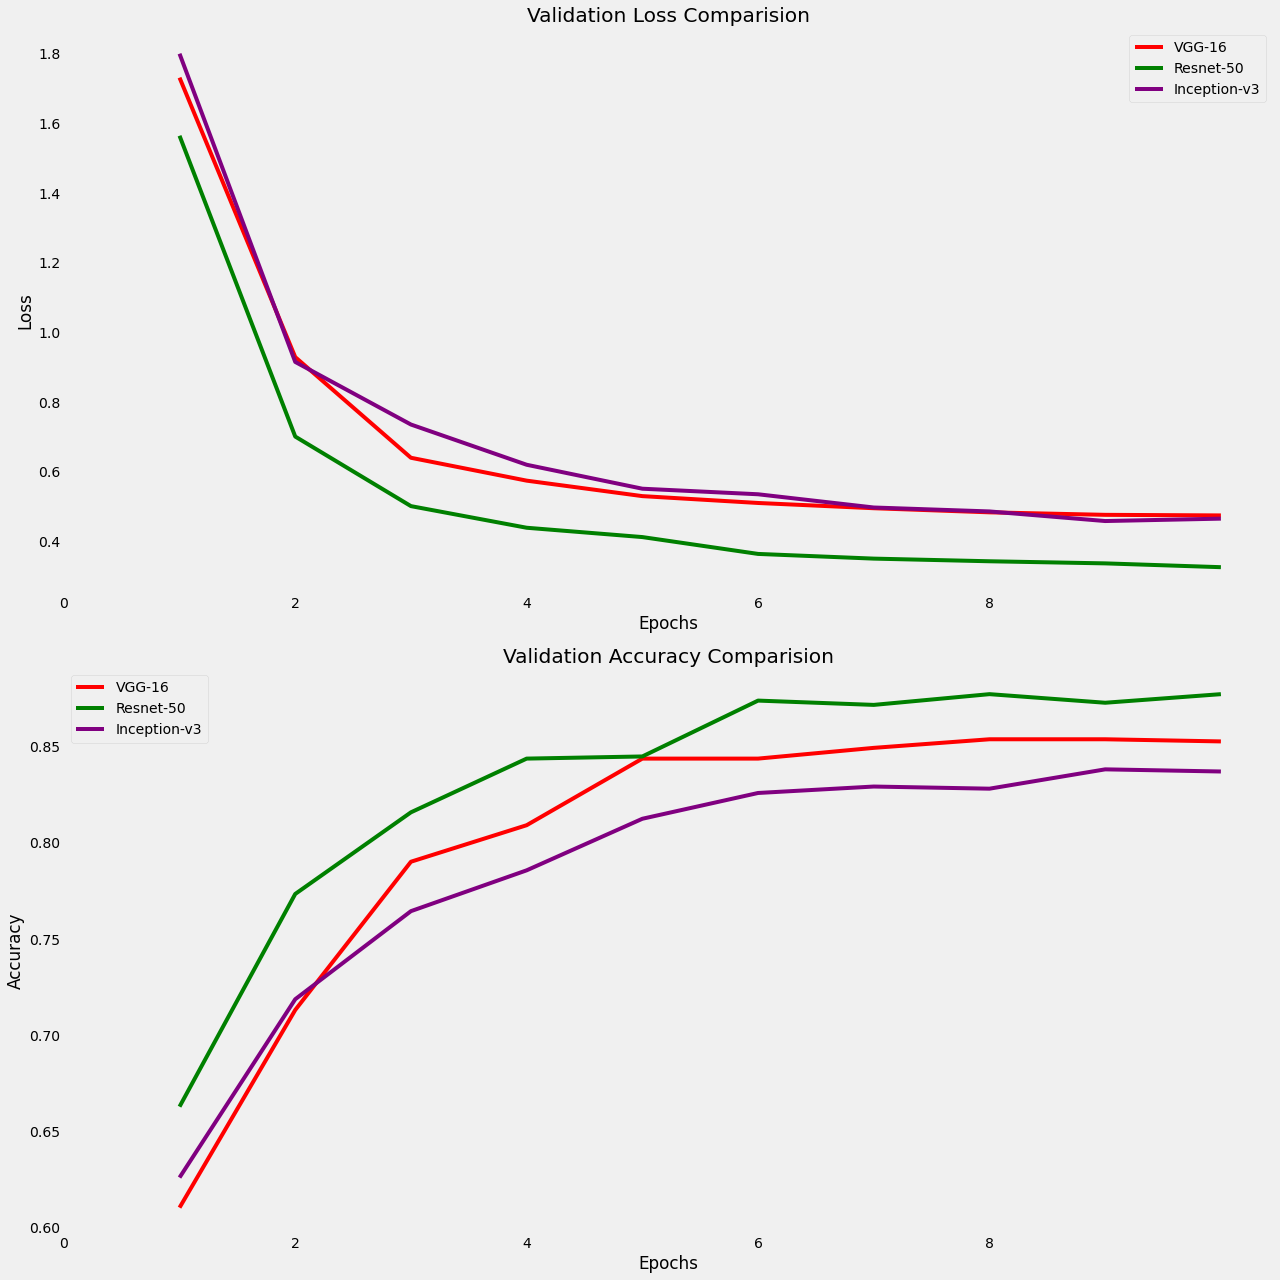

In [13]:
TransModels.plot_multiple_metric()

### It can be clearly seen that ResNet turns out to be the best model, followed by VGG and then followed by Inception

# Thank You